In [ ]:
# # Copy dataset
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir /content/data
# !cp -R "/content/drive/MyDrive/Colab Notebooks/skin-cancer/data/test" /content/data

In [ ]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader

import torch

from sklearn.metrics import roc_curve, auc

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Inference

In [ ]:
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']
n_classes = len(classes)

In [ ]:
# Dataset statistics

mean = [0.7116625905036926, 0.584557056427002, 0.5350210666656494]
std = [0.14735904335975647, 0.16540414094924927, 0.18036234378814697]

In [ ]:
# Load the data

transform = Compose([Resize(224), CenterCrop(224), ToTensor(),  # Preprocess the images and convert them to tensors
                     Normalize(mean=mean, std=std)  # Normalization
                     ])
test_data = ImageFolder('data/test', transform=transform)

In [ ]:
# Use DataLoader to iterate over the dataset using batches

num_workers = 0
batch_size = 32

test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [ ]:
# Load trained model

model = torch.load('out/model.pth', map_location=torch.device('cpu'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Loading the labels

ground_truth = pd.read_csv('https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv')
ground_truth.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0012086,0.0,1.0
1,ISIC_0012092,0.0,0.0
2,ISIC_0012095,0.0,0.0
3,ISIC_0012134,0.0,1.0
4,ISIC_0012136,0.0,1.0


In [ ]:
ground_truth['nevus'] = 1 - (ground_truth['melanoma']+ground_truth['seborrheic_keratosis'])

In [ ]:
ground_truth.sort_values(by=['melanoma', 'nevus'], ascending=False, inplace=True)

In [ ]:
filenames = []
for i in range(len(test_data)):
    filename = test_data.imgs[i][0]
    filenames.append(filename.split('/')[-1][:-4])

assert filenames==list(ground_truth['image_id'])

In [ ]:
# Get predictions for each image in the test set

list_of_predictons = []
for data, target in test_loader:
    with torch.no_grad():
        output = model(data)
        prob = torch.softmax(output, dim=1).numpy()
    list_of_predictons.append(prob)
final_prediciton = np.vstack(list_of_predictons)
m = final_prediciton[:,0]
s = final_prediciton[:,2]

In [ ]:
# Save results in a dataframe

results = pd.DataFrame({'image_id': filenames, 'melanoma': m, 'seborrheic_keratosis': s})

## Malignant or Benign

Melanomas are malignant lesions, while the other two types are benign. A binary classification task would be to identify whether a lesion is benign or malignant.

In [ ]:
y_true, y_score = ground_truth['melanoma'].to_numpy(), results['melanoma'].to_numpy()

In [ ]:
fpr, tpr, thres = roc_curve(y_true, y_score)

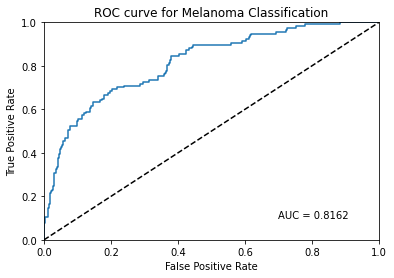

In [ ]:
# Plot ROC curve with TPR and FPR as axes
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Melanoma Classification')
plt.text(.7, .1, 'AUC = {:.4f}'.format(auc(fpr, tpr)))
plt.show()

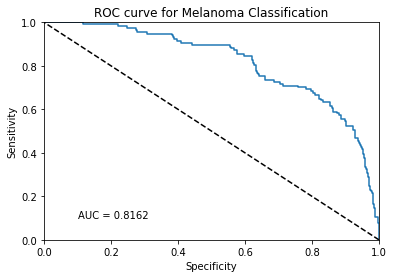

In [ ]:
# Plot ROC curve with Sensitivity and Specificty as axes
plt.plot(1-fpr, tpr)
plt.plot([1, 0], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve for Melanoma Classification')
plt.text(.1, .1, 'AUC = {:.4f}'.format(auc(fpr, tpr)))
plt.show()

In [ ]:
threshold = 0.5
tol = 0.003
print('For a decision threshold of {}:'.format(threshold))
print('    Sensitivity: {:.2f}%'.format(tpr[np.abs(thres - threshold)<tol].item()*100))
print('    Specificity: {:.2f}%'.format((1 - fpr[np.abs(thres - threshold)<tol].item())*100))

For a decision threshold of 0.5:
    Sensitivity: 44.44%
    Specificity: 94.20%


In [ ]:
threshold = 0.1
tol = 0.003
print('For a decision threshold of {}:'.format(threshold))
print('    Sensitivity: {:.2f}%'.format(tpr[np.abs(thres - threshold)<tol].item()*100))
print('    Specificity: {:.2f}%'.format((1 - fpr[np.abs(thres - threshold)<tol].item())*100))

For a decision threshold of 0.1:
    Sensitivity: 64.10%
    Specificity: 83.44%


## Melanocytic or Keratinocytic

We can also classify these lesions according to their cellular origin: melanocytic (melanoma, nevus) or keratinocytic (seborrheic_keratosis).

In [ ]:
y_true, y_score = ground_truth['seborrheic_keratosis'].to_numpy(), results['seborrheic_keratosis'].to_numpy()

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_score)

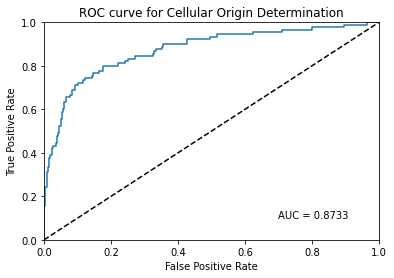

In [ ]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Cellular Origin Determination')
plt.text(.7, .1, 'AUC = {:.4f}'.format(auc(fpr, tpr)))
plt.show()